# Import libs

In [21]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os

import scipy.io
import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

sigma = 100
sigma_ = sigma/255.

# Load image

In [22]:
file_name  = 'data/denoising/denoising.mat'
# ensure dimensions [0][1] are divisible by 32 (or 2^depth)!

mat = scipy.io.loadmat(file_name)
img_np = mat["image"]
img_np = img_np.transpose(2,0,1)
img_var = torch.from_numpy(img_np).type(dtype)
img_noisy_np = get_noisy_image(img_np, sigma_)
img_noisy_var = torch.from_numpy(img_noisy_np).type(dtype)
#img_noisy_np = mat["image_noisy"]
#img_noisy_np = img_noisy_np.transpose(2,0,1)
#img_noisy_var = torch.from_numpy(img_noisy_np).type(dtype)


### Visualize

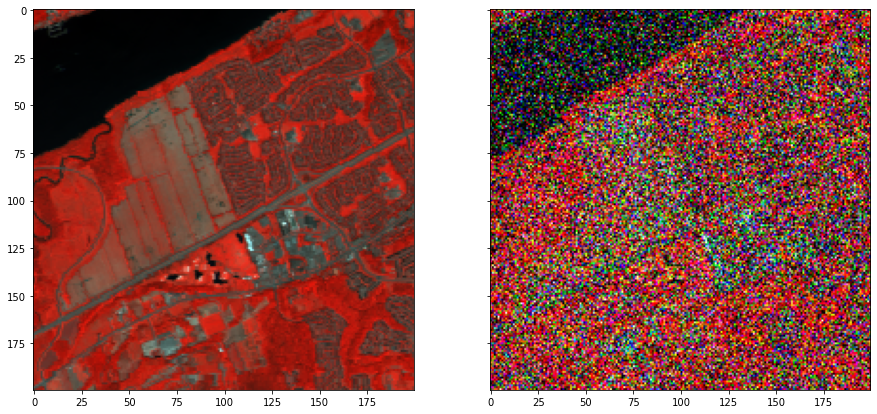

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
ax1.imshow(torch.stack((img_var[56,:,:].cpu(),img_var[26,:,:].cpu(),img_var[16,:,:].cpu()),2))
ax2.imshow(torch.stack((img_noisy_var[56,:,:].cpu(),img_noisy_var[26,:,:].cpu(),img_noisy_var[16,:,:].cpu()),2))
plt.show()

# Setup

In [6]:
method = '2D'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 0.03 # 0 0.01 0.05 0.08
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
exp_weight=0.99

show_every = 200
save_every = 200

num_iter = 1801
input_depth = img_np.shape[0]  

net = skip(input_depth, img_np.shape[0],  
       num_channels_down = [128]*5,
       num_channels_up =   [128]*5,
       num_channels_skip =    [4]*5,  
       filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
       upsample_mode='bilinear', # downsample_mode='avg',
       need1x1_up=False,
       need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

    
net_input = get_noise(input_depth, method, (img_np.shape[1], img_np.shape[2])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_var = img_noisy_var[None, :].cuda()

Number of params: 2317632


# Optimize

Starting optimization with ADAM


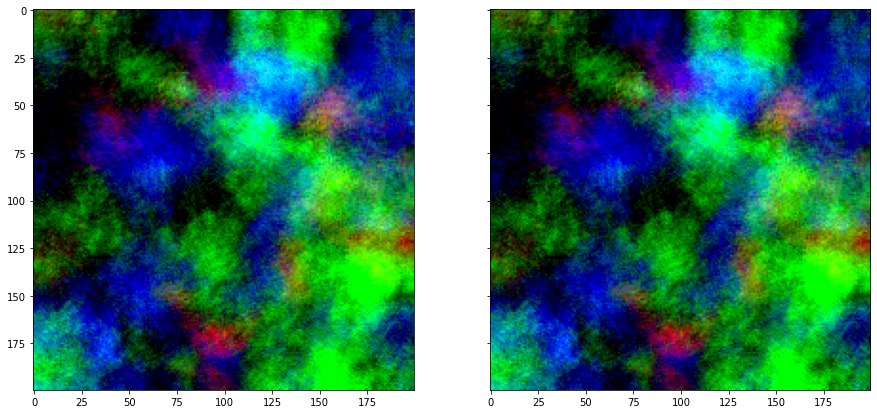

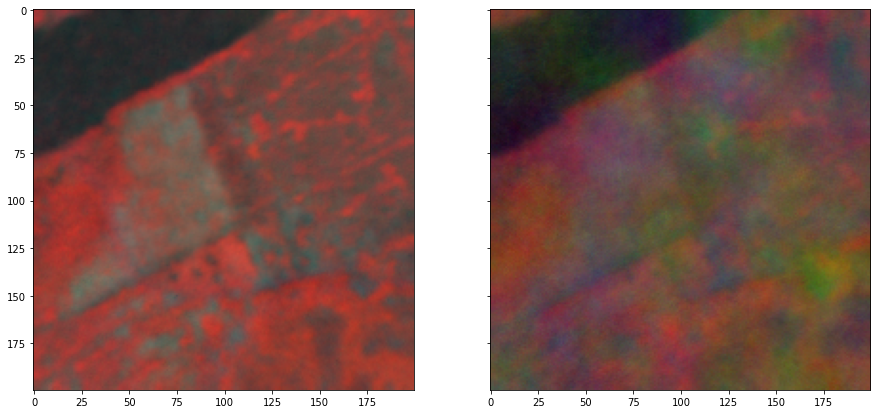

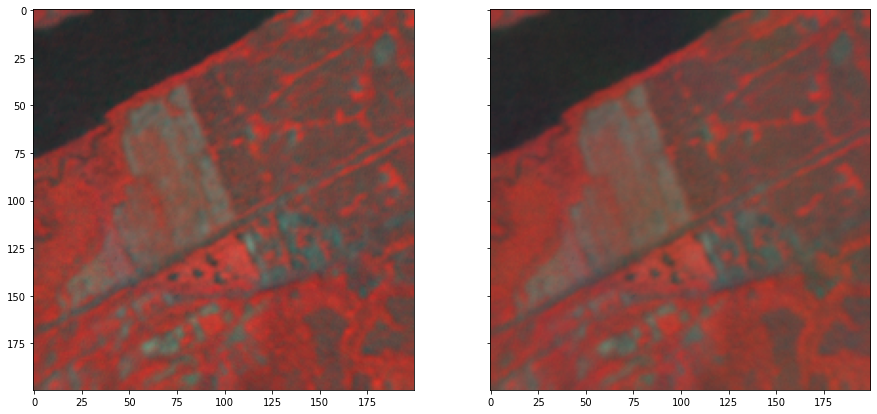

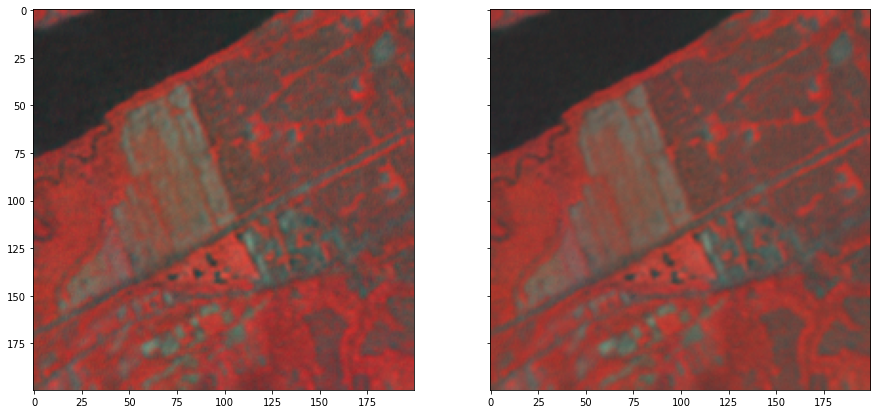

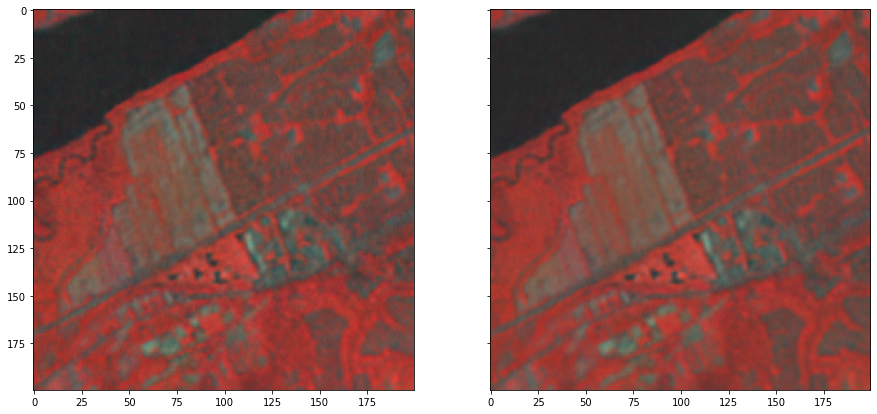

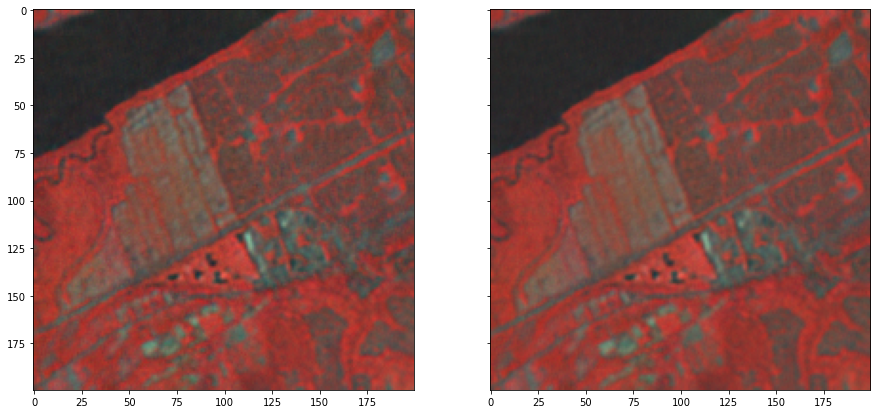

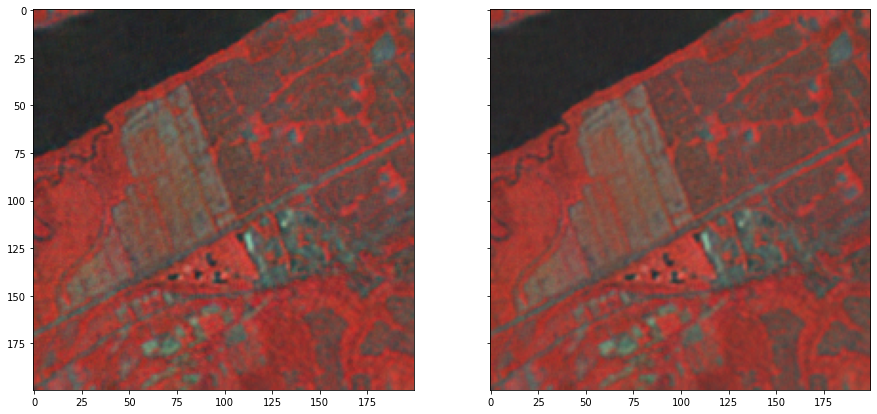

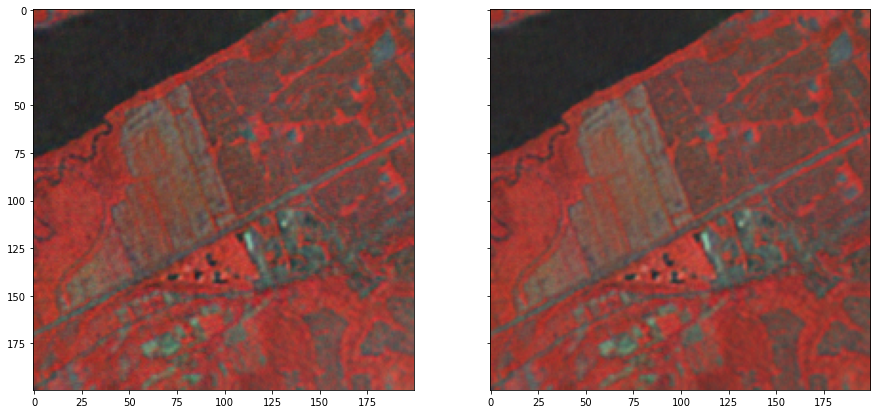

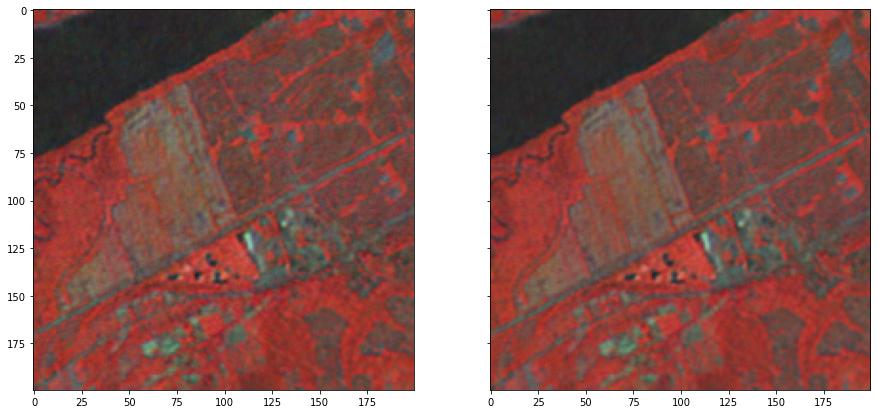

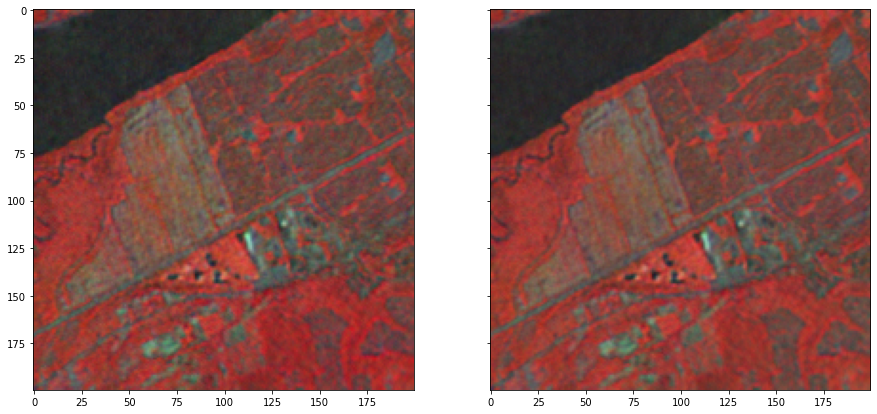

In [9]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_var)
    total_loss.backward()
    
    out_np = out.detach().cpu().squeeze().numpy()
    out_avg_np = out_avg.detach().cpu().squeeze().numpy()

    psrn_noisy = peak_signal_noise_ratio(img_noisy_np.astype(np.float32), np.clip(out_np, 0, 1))  
    psrn_gt    = peak_signal_noise_ratio(img_np.astype(np.float32), np.clip(out_np, 0, 1)) 
    psrn_gt_sm = peak_signal_noise_ratio(img_np.astype(np.float32), np.clip(out_avg_np, 0, 1)) 
    print ('Iteration %05d    Loss %f  PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_gt, psrn_gt_sm), '\r', end='')
    
    if i % show_every == 0:
        out_np = np.clip(out_np, 0, 1)
        out_avg_np = np.clip(out_avg_np, 0, 1)
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
        ax1.imshow(np.stack((out_np[56,:,:],out_np[26,:,:],out_np[16,:,:]),2))
        ax2.imshow(np.stack((out_avg_np[56,:,:],out_avg_np[26,:,:],out_avg_np[16,:,:]),2))
        plt.show()
       
    
    if  i % save_every == 0:
        scipy.io.savemat("results/result_denoising_2D_it%d.mat" % (i), {'pred':out_np.transpose(1,2,0),
                                                                              'pred_avg':out_avg_np.transpose(1,2,0)})


    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.detach().copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [10]:
file_name = "results/result_denoising_2D_it1800.mat"
mat = scipy.io.loadmat(file_name)

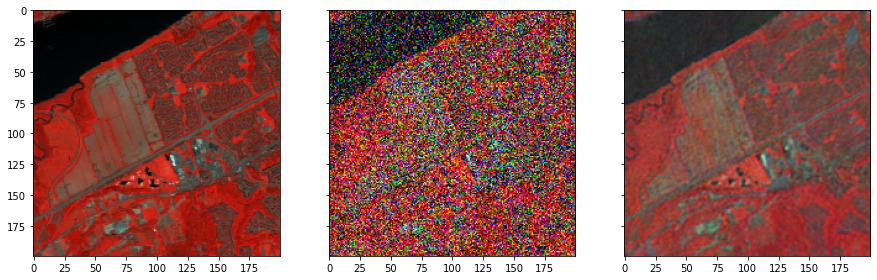

In [15]:
result_np = mat["pred"]
result_np = result_np.transpose(2,0,1)
result_np_avg = result_np * exp_weight +result_np * (1 - exp_weight)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(np.stack((img_np[56,:,:],img_np[26,:,:],img_np[16,:,:]),2))
ax2.imshow(np.stack((img_noisy_np[56,:,:],img_noisy_np[26,:,:],img_noisy_np[16,:,:]),2))
ax3.imshow(np.stack((result_np[56,:,:],result_np[26,:,:],result_np[16,:,:]),2))
plt.show()